In [4]:
import kagglehub
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision

# GPU Setting

In [5]:
mixed_precision.set_global_policy('mixed_float16')

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# DataSet Loading

In [6]:
path = kagglehub.dataset_download("mohitsingh1804/plantvillage")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\EXO\.cache\kagglehub\datasets\mohitsingh1804\plantvillage\versions\1


# Pre-Processing

- Data-Cleaning

In [7]:
# پاکسازی دیتاست

train_data_path = os.path.join(path, 'PlantVillage', 'train')
validation_data_path = os.path.join(path, 'PlantVillage', 'val')

# مسیر برای کپی داده های تمیز
cleaned_path = os.path.join('dataset', 'cleaned_plantvillage')
train_cleaned_path = os.path.join(cleaned_path, 'train')
validation_cleaned_path = os.path.join(cleaned_path, 'validation')
if not os.path.exists(cleaned_path):
    os.makedirs(cleaned_path)
    os.makedirs(train_cleaned_path)
    os.makedirs(validation_cleaned_path)

# تابع برای چک کردن کیفیت تصاویر
def check_image_quality(image_path):
  img = cv2.imread(image_path)
  if img is None or np.all(img < 30) or np.all(img > 230) or img.shape[0] < 128 or img.shape[0] < 128:
    return False
  else:
    return True


# تابع برای تنظیم کنتراست تصاویر
def clean_image(image_path, output_path):
    img = cv2.imread(image_path)

    # تنظیم روشنایی و کنتراست
    # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    # l, a, b = cv2.split(lab)
    # l_equalized = clahe.apply(l)
    # lab_equalized = cv2.merge((l_equalized, a, b))
    # cleaned_img = cv2.cvtColor(lab_equalized, cv2.COLOR_LAB2RGB)

    # ذخیره تصویر تمیز
    cv2.imwrite(output_path, img)


# بررسی تصاویر ترین
for class_name in os.listdir(train_data_path):
    class_path = os.path.join(train_data_path, class_name)
    if os.path.isdir(class_path):
        # ایجاد پوشه برای هر کلاس توی دیتاست تمیز
        class_cleaned_path = os.path.join(train_cleaned_path, class_name)
        if not os.path.exists(class_cleaned_path):
            os.makedirs(class_cleaned_path)

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if check_image_quality(image_path):
                # تنظیم کنتراست و ذخیره تصویر
                output_path = os.path.join(class_cleaned_path, image_name)
                clean_image(image_path, output_path)


# بررسی تصاویر ولیدیشن
for class_name in os.listdir(validation_data_path):
    class_path = os.path.join(validation_data_path, class_name)
    if os.path.isdir(class_path):
        # ایجاد پوشه برای هر کلاس توی دیتاست تمیز
        class_cleaned_path = os.path.join(validation_cleaned_path, class_name)
        if not os.path.exists(class_cleaned_path):
            os.makedirs(class_cleaned_path)

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if check_image_quality(image_path):
                # تنظیم کنتراست و ذخیره تصویر
                output_path = os.path.join(class_cleaned_path, image_name)
                clean_image(image_path, output_path)

- Number of samples

In [8]:
# تعداد نمونه های هر کلاس توی داده ترین

class_counts = []
for class_name in os.listdir(os.path.join(cleaned_path, 'train')):
  class_len = len(os.listdir(os.path.join(cleaned_path, 'train', class_name)))
  class_counts.append([class_name, class_len])

print(f'Number of Classes: {len(class_counts)}')
class_counts = dict(class_counts)
print(class_counts)

Number of Classes: 38
{'Apple___Apple_scab': 504, 'Apple___Black_rot': 496, 'Apple___Cedar_apple_rust': 220, 'Apple___healthy': 1316, 'Blueberry___healthy': 1202, 'Cherry_(including_sour)___healthy': 684, 'Cherry_(including_sour)___Powdery_mildew': 842, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 410, 'Corn_(maize)___Common_rust_': 953, 'Corn_(maize)___healthy': 929, 'Corn_(maize)___Northern_Leaf_Blight': 788, 'Grape___Black_rot': 944, 'Grape___Esca_(Black_Measles)': 1107, 'Grape___healthy': 339, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 861, 'Orange___Haunglongbing_(Citrus_greening)': 4405, 'Peach___Bacterial_spot': 1838, 'Peach___healthy': 288, 'Pepper,_bell___Bacterial_spot': 797, 'Pepper,_bell___healthy': 1183, 'Potato___Early_blight': 800, 'Potato___healthy': 121, 'Potato___Late_blight': 800, 'Raspberry___healthy': 297, 'Soybean___healthy': 4072, 'Squash___Powdery_mildew': 1468, 'Strawberry___healthy': 364, 'Strawberry___Leaf_scorch': 887, 'Tomato___Bacterial_spot': 

- Data Augmentation and Loading

In [9]:
# تنظیم سید برای شافل یکسان در هر بار اجرا
np.random.seed(42)
tf.random.set_seed(42)


# تعریف ژنراتور های لود و آگمنتیشن داده ها
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # تبدیل تصاویر به بهترین و سازگارترین حالت برای ورودی مدل پریترِیند
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2]
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)


# لود دیتا از دایرکتوری ها
train_generator = train_datagen.flow_from_directory(
    train_cleaned_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    seed=42,
)

validation_generator = validation_datagen.flow_from_directory(
    validation_cleaned_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    seed=42,
)


# دیدن ایندکس مربوط به هر کلاس
print(train_generator.class_indices)

Found 43444 images belonging to 38 classes.
Found 10861 images belonging to 38 classes.
{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato

- Class Imbalance

In [10]:
# دیدن تعداد نمونه های هر کلاس
print(np.bincount(train_generator.classes))


# حل مشکل کلاس ایمبالانس
class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(38),
    y=train_generator.classes,
)

class_weights_dict = dict(enumerate(class_weights))
print('Class weights:', class_weights_dict)

[ 504  496  220 1316 1202  842  684  410  953  788  929  944 1107  861
  339 4405 1838  288  797 1183  800  800  121  297 4072 1468  887  364
 1702  800 1527  761 1417 1341 1123 4286  299 1273]
Class weights: {0: 2.268379281537176, 1: 2.3049660441426147, 2: 5.196650717703349, 3: 0.8687410014397696, 4: 0.9511340747876347, 5: 1.3577947243405426, 6: 1.6714373653431824, 7: 2.788446726572529, 8: 1.199646545534876, 9: 1.4508415709324072, 10: 1.2306384907370687, 11: 1.2110838537020518, 12: 1.0327580468787143, 13: 1.327831774558347, 14: 3.3724576929048284, 15: 0.2595376067865464, 16: 0.6220147757860375, 17: 3.9696637426900585, 18: 1.4344581654890047, 19: 0.966410108110513, 20: 1.4290789473684211, 21: 1.4290789473684211, 22: 9.448455850369726, 23: 3.849370902002481, 24: 0.28076207217454247, 25: 0.7787896170945073, 26: 1.2889099863525781, 27: 3.1408328513591672, 28: 0.6717174840744635, 29: 1.4290789473684211, 30: 0.7486988591321132, 31: 1.5023168960509026, 32: 0.8068194480555658, 33: 0.852545233

# Hyperparameter Tuning

In [11]:
# تعریف تابع ساخت مدل برای کراس تیونر
def model_builder(hp):
    # تعریف مدل بدون لایه های دنس
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # فریز کردن
    base_model.trainable = False

    # هایپرپارامتر ها
    learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
    unfreeze_layers = hp.Int('unfreeze_layers', min_value=5, max_value=12, step=2)

    # اضافه کردن لایه های جدید
    x = base_model.output # خروجی لایه آخر بیس مدل
    x = keras.layers.GlobalAveragePooling2D()(x) # کاهش ابعاد به یک بردار
    output_layer = keras.layers.Dense(38, activation='softmax', dtype='float32')(x) # لایه خروجی به صورت 32 بیت چون برای سرعت کارت گرافیک، 16 بیت کرده بودیم

    # ساخت مدل نهایی
    model = keras.models.Model(inputs=base_model.input, outputs=output_layer)

    # آنفریز کردن لایه های آخر بیس مدل
    for layer in model.layers[-unfreeze_layers:]:
      layer.trainable = True

    for layer in model.layers[:-unfreeze_layers]:
        layer.trainable = False

    # کامپایل مدل
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# پیدا کردن بهترین هایپرپارامتر ها با کراس تیونر
tuner = kt.Hyperband( # (زمانبرتر) برای یادگیری از نتایج قبلی kt.BayesianOptimization یا
    model_builder,
    objective='val_accuracy', # هدف افزایش اکیورسی
    max_epochs=7, # بیشترین تعداد ایپاک برای هر مدل
    factor=3, # ضریب کاهش مدل ها
    directory='best_hps', # پوشه برای ذخیره نتایج
    project_name='finding_best_hps',
)

tuner.search(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=7,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // train_generator.batch_size,
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'The best Hyperparameters are: {best_hps}')

# ساخت مدل با بهترین هایپرپارامتر ها
best_model = tuner.hypermodel.build(best_hps)

# خلاصه مدل
best_model.summary()

Reloading Tuner from best_hps\finding_best_hps\tuner0.json
The best Hyperparameters are: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x00000288C3614A00>
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
  

# Fine-Tuning

In [13]:
# تعریف کال بک و لرنینگ ریت اسکجولر
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# آموزش مدل
history = best_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // train_generator.batch_size,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, lr_scheduler],
)

# ارزیابی مدل
val_loss, val_accuracy = best_model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# ذخیره مدل
# best_model.save('plant_disease_model.h5')
best_model.save('plant_disease_model', save_format='tf')

Epoch 1/15
678/678 [==============================] - 486s 717ms/step - loss: 0.1067 - accuracy: 0.9735 - val_loss: 0.1217 - val_accuracy: 0.9670 - lr: 0.0100
Epoch 2/15
678/678 [==============================] - 444s 655ms/step - loss: 0.0796 - accuracy: 0.9802 - val_loss: 0.1851 - val_accuracy: 0.9538 - lr: 0.0100
Epoch 3/15
678/678 [==============================] - 492s 725ms/step - loss: 0.0765 - accuracy: 0.9785 - val_loss: 0.0952 - val_accuracy: 0.9747 - lr: 0.0100
Epoch 4/15
678/678 [==============================] - 494s 728ms/step - loss: 0.0617 - accuracy: 0.9846 - val_loss: 0.1555 - val_accuracy: 0.9665 - lr: 0.0100
Epoch 5/15
678/678 [==============================] - 472s 696ms/step - loss: 0.0648 - accuracy: 0.9841 - val_loss: 0.1996 - val_accuracy: 0.9592 - lr: 0.0100
Epoch 6/15
678/678 [==============================] - 281s 414ms/step - loss: 0.0243 - accuracy: 0.9929 - val_loss: 0.0865 - val_accuracy: 0.9817 - lr: 0.0050
Epoch 7/15
678/678 [==========================

INFO:tensorflow:Assets written to: plant_disease_model\assets


INFO:tensorflow:Assets written to: plant_disease_model\assets


# Model Performance

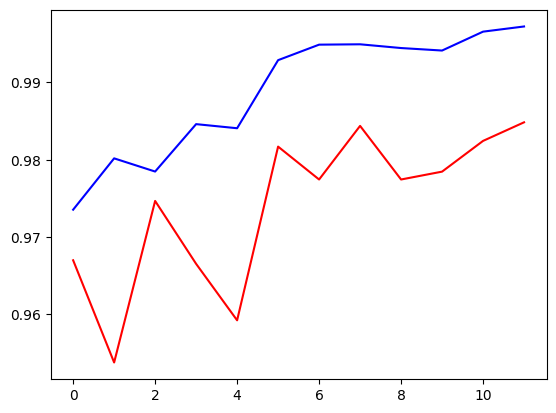

In [15]:
# عملکرد مدل روی اکیورسی

plt.plot(history.history['accuracy'], color='blue') # داده ترین
plt.plot(history.history['val_accuracy'], color='red') # داده تست

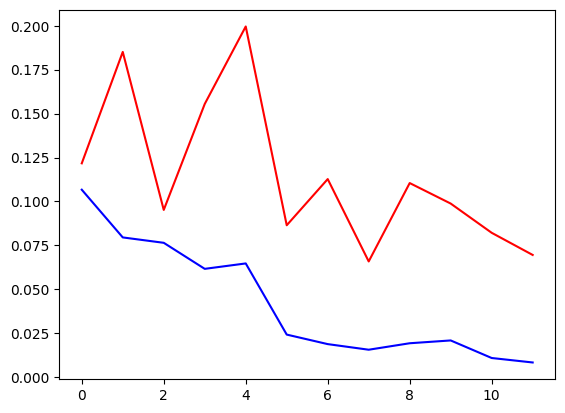

In [16]:
# عملکرد مدل روی لاس

plt.plot(history.history['loss'], color='blue') # داده ترین
plt.plot(history.history['val_loss'], color='red') # داده تست

# Explainability: GRAD-CAM

1/1 [==============================] - 1s 519ms/step


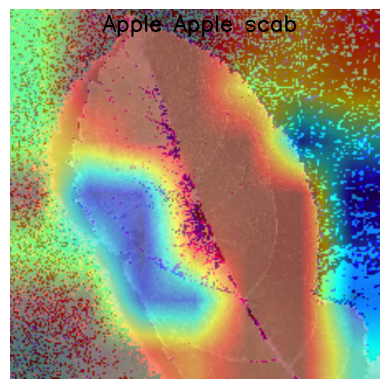

In [103]:
# تابع ساخت هیت مپ
def make_gradcam_heatmap(img_array, model, last_conv_layer_name='conv5_block3_out', pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # محاسبه گرادیان ها
    with tf.GradientTape() as tape: # برای ذخیره محاسبات
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]


    # گرادیان نسبت به خروجی لایه کانولوشن
    grads = tape.gradient(class_channel, conv_outputs)

    # میانگین گیری از گرادیان ‌ها در هر کانال
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()

    # وزن دادن به خروجی لایه ها با میانگین گرادیان
    conv_outputs = conv_outputs.numpy()[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis] # اضافه کردن بعد برای ضرب ماتریسی
    heatmap = tf.squeeze(heatmap)
    # نرمالایز
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-7) # برای جلوگیری از خطای تقسیم بر 0

    return heatmap.numpy()


# تابع ترکیب تصویر با هیت مپ
def display_heatmap(img, heatmap, alpha=0.5, beta=0.5):
    heatmap = np.array(heatmap, dtype=np.float32)
    heatmap = cv2.resize(heatmap, (img.shape[2], img.shape[1])) # چون (1,224,224,3) هست
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    combined_img = cv2.addWeighted(img[0].astype(np.uint8), alpha, heatmap, beta, 0)

    return combined_img



img_path = 'test_img.png'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

# لود مدل
model = keras.models.load_model('plant_disease_model')

# پیشبینی مدل
model_prediction = model.predict(img)

class_names = [
    'Apple Apple scab',
    'Apple Black rot',
    'Apple Cedar apple rust',
    'Apple healthy',
    'Blueberry healthy',
    'Cherry (including sour) Powdery mildew',
    'Cherry (including sour) healthy',
    'Corn (maize) Cercospora leaf spot Gray leaf spot',
    'Corn (maize) Common rust ',
    'Corn (maize) Northern Leaf Blight',
    'Corn (maize) healthy',
    'Grape Black rot',
    'Grape Esca (Black Measles)',
    'Grape Leaf blight (Isariopsis Leaf Spot)',
    'Grape healthy',
    'Orange Haunglongbing (Citrus greening)',
    'Peach Bacterial spot',
    'Peach healthy',
    'Pepper, bell Bacterial spot',
    'Pepper, bell healthy',
    'Potato Early blight',
    'Potato Late blight',
    'Potato healthy',
    'Raspberry healthy',
    'Soybean healthy',
    'Squash Powdery mildew',
    'Strawberry Leaf scorch',
    'Strawberry healthy',
    'Tomato Bacterial spot',
    'Tomato Early blight',
    'Tomato Late blight',
    'Tomato Leaf Mold',
    'Tomato Septoria leaf spot',
    'Tomato Spider mites Two-spotted spider mite',
    'Tomato Target Spot',
    'Tomato Tomato Yellow Leaf Curl Virus',
    'Tomato Tomato mosaic virus',
    'Tomato healthy'
]

predicted_class = class_names[np.argmax(model_prediction)]

# ساخت هیت مپ
heatmap = make_gradcam_heatmap(img, model)
# ترکیب هیت مپ با تصویر اصلی
combined_img = display_heatmap(img, heatmap)
resized_combined_img = cv2.resize(combined_img, (512, 512))

final_image = cv2.putText(resized_combined_img.copy(), predicted_class, (128, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

# نمایش با اطلاعات رنگ ها
# plt.imshow(final_image, cmap='jet')
# plt.colorbar()
plt.imshow(final_image)
plt.axis('off')

plt.show()